In [12]:
import numpy as np
from open3d import *
import open3d as o3d
from sklearn.neighbors import KDTree
import scipy
from scipy.sparse import csr_matrix
import networkx as nx
import pandas as pd
from itertools import compress
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def zero_to_infinity():
    i = 0
    while True:
        yield i
        i += 1

pcd = o3d.io.read_point_cloud("/media/capte-gpu-2/Seagate Basic/DOWN_FOLDERS/SSSC-master/test2_subsample22.txt", format = 'xyz')

cloud = np.array(pcd.points)
print(cloud, np.shape(cloud))

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=10))
featuree = np.asarray(pcd.normals)
print(featuree, np.shape(featuree))

ft_threshold = 0.5
k = 10

WARNING - 2023-10-13 13:31:08,196 - __init__ - 
Bad key text.latex.preview in file /home/capte-gpu-2/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution
WARNING - 2023-10-13 13:31:08,197 - __init__ - 
Bad key mathtext.fallback_to_cm in file /home/capte-gpu-2/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution
WARNING - 2023-10-13 13:31:08,198 - __init__ - 
Bad key savefig.jpeg_quality in file /home/capte-gpu-2/anaconda3/lib/pytho

[[-23.42200089 -10.47599983 -26.94199944]
 [-23.72999954  -7.43900013 -27.0170002 ]
 [-23.3239994   -9.86100006 -26.87299919]
 ...
 [-22.49300003  -8.28999996 -27.36800003]
 [-22.31999969  -9.33300018 -27.37899971]
 [-22.48399925  -7.94199991 -27.36199951]] (81111, 3)
[[ 0.87968587  0.35666569  0.31455106]
 [ 0.38878457 -0.69375719 -0.60625697]
 [ 0.62331226 -0.52024162 -0.58380689]
 ...
 [-0.21216726  0.26076639 -0.94179931]
 [ 0.82536053 -0.56278495  0.04531117]
 [-0.19294823  0.53270852 -0.82401008]] (81111, 3)


In [10]:
def GraphRG (X, feature, k, ft_threshold):

    n_point = np.shape(X)
    n_point = n_point[0]

    tree = KDTree(X)
    distance, neighbors = tree.query(X, 11)

    neighbors = neighbors[:, 1:]
    distance  = distance[:, 1:]

    source = np.repeat(np.arange(0,n_point), k)
    target = np.reshape(neighbors, [1, k * n_point]).T  #target = np.reshape(neighbors.T, [1, k * n_point]).T"
    target = target.flatten()

    dt = np.mean(distance, axis=1) + 1 * np.std(distance, ddof=1, axis=1)

    prune = distance.T > dt.T
    prune = prune *1
    prune = prune.T

    pruned = np.reshape(prune, [1, k * n_point]).T

    maxd = np.mean(distance[:,-1]) + 1 * np.std(distance[:,-1])

    prune2 = distance > maxd
    prune2 = prune2*1

    pruned2 = np.reshape(prune2, [1, k * n_point]).T 

    selfedge = np.equal(source, target)
    selfedge = selfedge * 1

    sell = selfedge 
    sell = [sell]

    sell = np.array(sell)

    to_remove =  pruned + pruned2 + sell.T 
    to_removee = to_remove.astype(bool)
    to_removee = to_removee[:,0]
    
    source = source[~to_removee]
    target = target[~to_removee]

    dv = np.full([max(source.shape)], np.nan)

    feature = feature[:,2]

    for j in range(0, max(source.shape)) : 
        dv[j] = np.abs(np.abs(feature[source[j]]) - np.abs(feature[target[j]]))

    source = source[dv <= ft_threshold]
    target = target[dv <= ft_threshold]

    Edge = np.stack((source, target), axis=-1)
    Edge2 = np.stack((Edge[:,1],Edge[:,0]), axis=-1)
    Edge = np.concatenate((Edge, Edge2))

    m = len(X[:,0])
    n = len(X[:,0])

    v = np.ones((len(Edge[:,0]),))

    i = Edge[:,0]
    j = Edge[:,1]

    adj = scipy.sparse.csr_matrix((np.array(v), (np.array(i), np.array(j))), shape=(m, n))
    
    Gp = nx.from_scipy_sparse_matrix(adj)
    components = list(nx.connected_components(Gp))

    df = {name:k for k,comp in enumerate(components) for name in comp}
    Label = pd.DataFrame.from_dict(df, orient='index', columns=['component'])
    Label = np.array(Label['component'])

    return Label, components
    

In [11]:
Label, components = GraphRG(cloud, featuree, k, ft_threshold)

Seg = []

for i in components :
    Segg = []
    
    for j in i :
        Segg.append(cloud[j]) 
    Seg.append(Segg)


lb = []
for i in components:
    lb.append(len(i))
 
lb = np.array(lb)


Seg_reserve = []
Seg_processing = []

for i in Seg:
    if len(i) <= 10 :
        Seg_reserve.append(i)
    else :
        Seg_processing.append(i)
          
for ii in zero_to_infinity():
    
    TMP = [0] * len(Seg_processing)
    indx = np.full((len(Seg_processing),), False, dtype=bool)


    print(len(Seg_processing))

    for i in range (0, len(Seg_processing)) :

        points_n = Seg_processing[i]
        points_n = np.array(points_n)

        points_nn = o3d.geometry.PointCloud()
        points_nn.points = o3d.utility.Vector3dVector(points_n)

        points_nn.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=10))
        normals = np.array(points_nn.normals)

        Label, components = GraphRG(np.array(points_nn.points), normals, k, ft_threshold)

        if max(Label) == 0 :
            indx[i] = True
            TMP[i] = []

        else :
            Seg = []
            for ib in components :
                Segg = []
                
                for j in ib :
                    Segg.append(np.array(points_nn.points)[j]) 
                Seg.append(Segg)

            TMP[i] = Seg

    print('###')  

    Seg = np.concatenate(TMP, axis=None)
    print(np.shape(Seg))

    unchange = list(compress(Seg_processing, indx))
    
    if sum(indx) == len(Seg_processing) or ii == 10 :
        print('DONE')
        Seg_final =  np.concatenate((Seg, Seg_reserve, unchange))
        break
        
    else :

        lb = []
        for ip in Seg:

            lb.append(len(ip))

        lb = np.array(lb)

        Seg_processing = Seg[lb > 10]
        Seg_reserve = np.concatenate((Seg_reserve, unchange, Seg[lb <= 10]))

print(np.shape(Seg_final))

148
###
(375,)
82


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###
(78,)
28


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###
(18,)
10


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###
(4,)
2


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###
(0,)
DONE
(1382,)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
import csv
import random

for i in Seg_final :

    lab = random.randint(1, 360)

    for j in i :

        dut = [[j[0],j[1],j[2], lab]]
        file = open('python_labelled.csv', 'a+', newline ='')

        with file:    
            write = csv.writer(file)
            write.writerows(dut)
    c = c+1

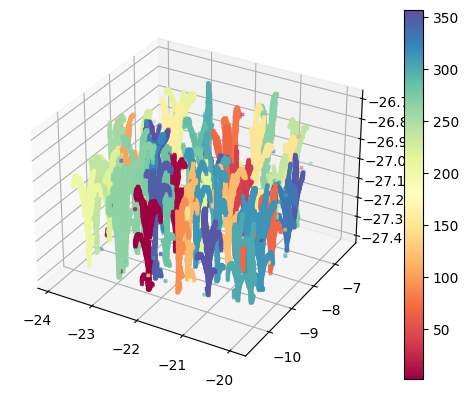

In [13]:
df = pd.read_csv("python_labelled.csv")
df = df.groupby('LABEL').filter(lambda x : len(x)>800)

x = df['x'].values
y = df['y'].values
z = df['z'].values
col = df['LABEL'].values

ax = plt.subplot(projection="3d")
sc = ax.scatter(x, y, z, c=col, marker='x', s=5, cmap="Spectral")

plt.colorbar(sc)
plt.show()